In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mstats  # 信頼区間を描くために
import stan  # pystan
%matplotlib inline

In [4]:
plt.style.use("ggplot")

In [5]:
df = pd.read_excel("./data/multilevel_modeling.xlsx")

In [6]:
df.head()

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1


In [7]:
df["id"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [8]:
groups = df.groupby(df["id"])  # id とdata(age, height)

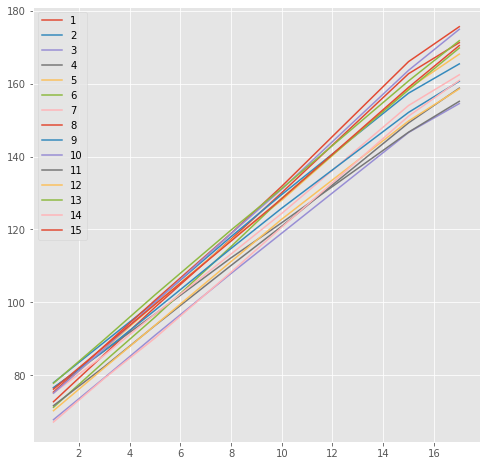

In [9]:
plt.figure(figsize=(8,8))
for name, group in groups:
    plt.plot(group["age"],group["height"],label=name)
plt.legend()

In [10]:
stan_model = """
data {
  int N;
  int N_id;
  real X[N];
  real Y[N];
  int<lower=1, upper=N_id> s_id[N];
}

parameters {
  real a0;
  real b0;
  real a_id[N_id];
  real b_id[N_id];
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

transformed parameters {
  real a[N_id];
  real b[N_id];
  for (n in 1:N_id){
    a[n] = a0 + a_id[n];
    b[n] = b0 + b_id[n];
  }
}

model {
  for (id in 1:N_id){
    a_id[id] ~ normal(0, s_a);
    b_id[id] ~ normal(0, s_b);
  }
  
  for (n in 1:N){
    Y[n] ~ normal(a[s_id[n]] * X[n] + b[s_id[n]], s_Y);
  }
}

"""

↑　個人ごとの傾きのためのブロック： transformed parameters（共通部分＋個人差）　　a0 +a_id[n]

In [11]:
stan_data = {"N":df.shape[0], "N_id":15, 
             "X":df["age"].values, 
             "Y":df["height"].values, 
             "s_id":df["id"].values}

In [1]:
# sm = pystan.StanModel(model_code=stan_model)

In [2]:
# fit = sm.sampling(data = stan_data, iter=3000, warmup=1000, chains=3, seed=123)

In [ ]:
# fit

In [12]:
import nest_asyncio
nest_asyncio.apply()

In [13]:
posterior = stan.build(stan_model, data=stan_data, random_seed=123)
fit = posterior.sample(num_chains=3, num_samples=2000, num_warmup=1000, save_warmup=0)

Building...

In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:7,
                 from /root/.cache/httpstan/4.7.2/models/4m3ufcri/model_4m3ufcri.cpp:2:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/io/dump.hpp: In member function ‘virtual std::vector<std::complex<double> > stan::io::dump::vals_c(const string&) const’:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/io/dump.hpp:694:52: warning: comparison of integer expressions of different signedness: ‘int’ and ‘std::vector<double, std::allocator<double> >::size_type’ {aka ‘long unsigned int’} [-Wsign-compare]
  694 |       for (comp_iter = 0, real_iter = 0; real_iter < val_r->second.first.size();
      |                                          ~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/io/dump.hpp:707:24: warning: comparison of integer expressions of different signedness: ‘int’ and ‘std::vector<int>::size_


Building: 31.1s, done.Messages from stanc:
Warning in '/tmp/httpstan_c1g1xm1r/model_4m3ufcri.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_c1g1xm1r/model_4m3ufcri.stan', line 6, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_c1g1xm1r/model_4m3ufcri.stan', line 7, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to


In [37]:
df_fit = fit.to_frame()
df_fit.describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
lp__,6000.0,-62.339608,4.862699,-83.267276,-65.440764,-61.965392,-58.855156,-47.829482
accept_stat__,6000.0,0.926627,0.092563,0.243011,0.900159,0.961701,0.989484,1.000000
stepsize__,6000.0,0.060083,0.002601,0.058181,0.058181,0.058308,0.063760,0.063760
treedepth__,6000.0,5.806833,0.547330,4.000000,6.000000,6.000000,6.000000,8.000000
n_leapfrog__,6000.0,73.034667,38.370390,15.000000,63.000000,63.000000,63.000000,319.000000
...,...,...,...,...,...,...,...,...
b.11,6000.0,66.110978,0.619682,63.733117,65.694004,66.105021,66.524508,68.900728
b.12,6000.0,65.758601,0.620134,63.107898,65.346362,65.749758,66.173661,68.456284
b.13,6000.0,72.234503,0.610085,69.452287,71.826965,72.235252,72.640932,74.764728


In [41]:
fit.values

<bound method Mapping.values of <stan.Fit>
Parameters:
    a0: ()
    b0: ()
    a_id: (15,)
    b_id: (15,)
    s_a: ()
    s_b: ()
    s_Y: ()
    a: (15,)
    b: (15,)
Draws: 6000>

In [17]:
# plt.figure(figsize=(12,20))
# fig = fit.plot()

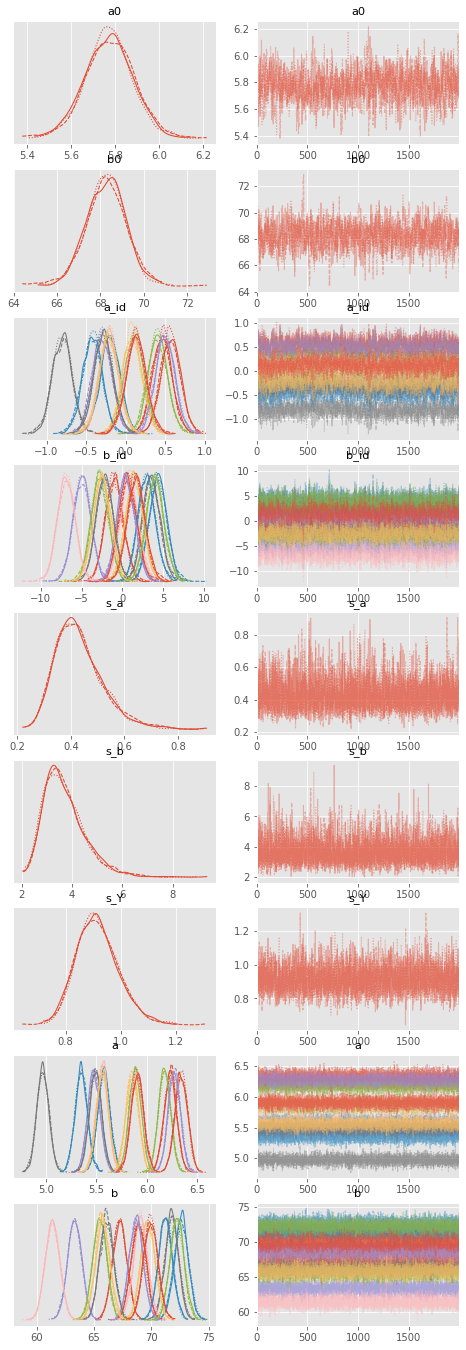

In [43]:
import arviz
arviz.plot_trace(fit, figsize=(8,24));

In [ ]:
# ms_a = fit.extract("a")["a"]
# ms_b = fit.extract("b")["b"]

In [23]:
ms_a = fit["a"].T
ms_b = fit["b"].T

In [49]:
x = np.arange(18)
df_b = pd.DataFrame([])
for i in range(18):
    df_b[i] = ms_a[:,0] * x[i] + ms_b[:,0]  # 0番目の人だけ（１番の人だけ）

In [50]:
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0)

In [51]:
df_0 = groups.get_group(1)  # IDを指定し、グループ化されたデータを取得（１番のひとだけ）

In [52]:
df_0.head()

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1


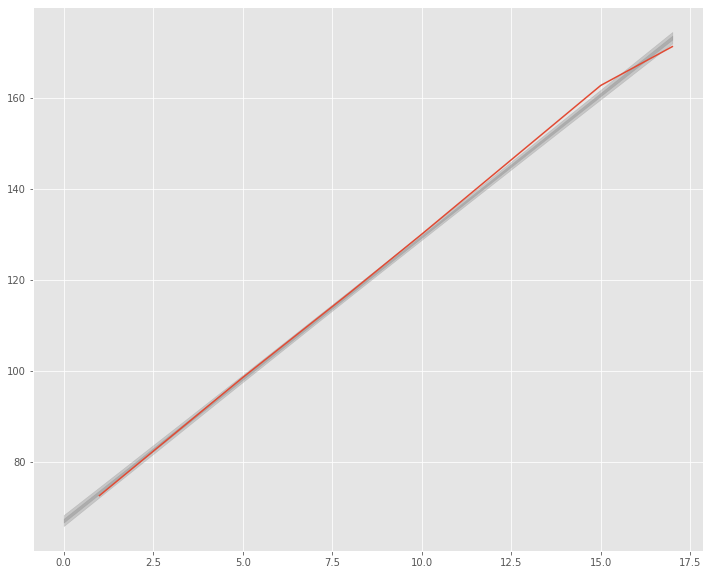

In [53]:
plt.figure(figsize=(12,10))
plt.plot(df_0["age"],df_0["height"])
plt.fill_between(x, low_y50, high_y50, alpha=0.6, color="darkgray")
plt.fill_between(x, low_y95, high_y95, alpha=0.3, color="gray")